In [214]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as sk_linear_model

In [39]:
# BEA -> Bureau of Economic Analysis in the US
# MSA -> metropolitan statistical area
# pcgmp -> gross metropolitan product per capita (ilke GDP per capita)
# pop -> population
# remaining columns -> % share each industry contributes to pcgmp
bea_df = pd.read_csv('bea-2006.txt')
bea_df

,MSA,pcgmp,pop,finance,prof.tech,ict,management
0,"Abilene, TX",24490,158700.0,0.09750,NaN,0.016210,NaN
1,"Akron, OH",32890,699300.0,0.12940,0.05440,NaN,0.054310
2,"Albany, GA",24270,163000.0,0.08217,NaN,0.007080,NaN
3,"Albany-Schenectady-Troy, NY",36840,850300.0,0.15780,0.09399,0.045110,NaN
4,"Albuquerque, NM",37660,816000.0,0.15990,0.09978,0.205000,0.006509
...,...,...,...,...,...,...,...
361,"Yakima, WA",25220,230100.0,0.09545,0.02223,0.004307,0.004824
362,"York-Hanover, PA",29480,414000.0,0.12220,0.03622,NaN,0.015000
363,"Youngstown-Warren-Boardman, OH-PA",26000,576200.0,0.12970,0.02670,0.013210,0.007208
364,"Yuba City, CA",21320,159800.0,0.15000,0.03229,0.008218,NaN


There are NaNs in the dataset which we need to deal with. First let's count.

In [40]:
# Important: we have NaNs in the dataset!
bea_df.isna().sum(axis=0)

MSA             0
pcgmp           0
pop             0
finance        12
prof.tech     112
ict            76
management    157
dtype: int64

There are a lot of NaNs in the industry columns but none in the pcgmp and pop columns. This is convenient because we don't need to do any data cleaning to compute the gross metropolitan product (by muliplying pcgmp with pop).

In [41]:
bea_df['gmp'] = bea_df['pcgmp'] * bea_df['pop']
bea_df

,MSA,pcgmp,pop,finance,prof.tech,ict,management,gmp
0,"Abilene, TX",24490,158700.0,0.09750,NaN,0.016210,NaN,3.886563e+09
1,"Akron, OH",32890,699300.0,0.12940,0.05440,NaN,0.054310,2.299998e+10
2,"Albany, GA",24270,163000.0,0.08217,NaN,0.007080,NaN,3.956010e+09
3,"Albany-Schenectady-Troy, NY",36840,850300.0,0.15780,0.09399,0.045110,NaN,3.132505e+10
4,"Albuquerque, NM",37660,816000.0,0.15990,0.09978,0.205000,0.006509,3.073056e+10
...,...,...,...,...,...,...,...,...
361,"Yakima, WA",25220,230100.0,0.09545,0.02223,0.004307,0.004824,5.803122e+09
362,"York-Hanover, PA",29480,414000.0,0.12220,0.03622,NaN,0.015000,1.220472e+10
363,"Youngstown-Warren-Boardman, OH-PA",26000,576200.0,0.12970,0.02670,0.013210,0.007208,1.498120e+10
364,"Yuba City, CA",21320,159800.0,0.15000,0.03229,0.008218,NaN,3.406936e+09


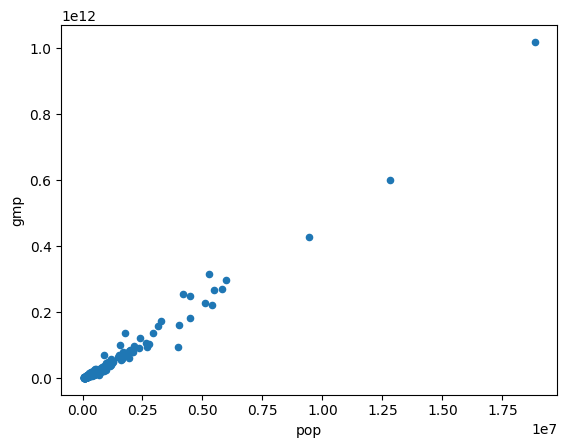

In [42]:
bea_df.plot('pop', 'gmp', kind='scatter');

Obviously (?) the GMP scales with the population, which seems to make sense because the larger the population the more money you'll make.

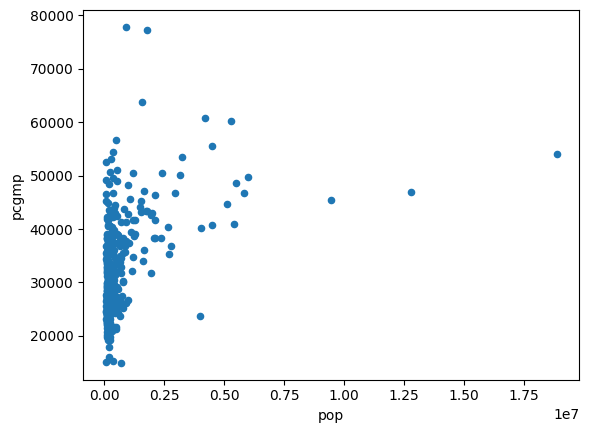

In [43]:
bea_df.plot('pop', 'pcgmp', kind='scatter');

On the other hand, the population size doesn't really seem to affect the GMP per capita too much: look at vertical cluster of points at `pop` = ~0.00e7, this shows that the same population gives vastly different GMPs per capita.

You could maybe argue that a larger population leads to a larger GMP per capita: look at the points in the range `pop` : [0.00e7, 0.50e7] and `pcgmp` : [30000, 60000], where there seems to be some correlation.

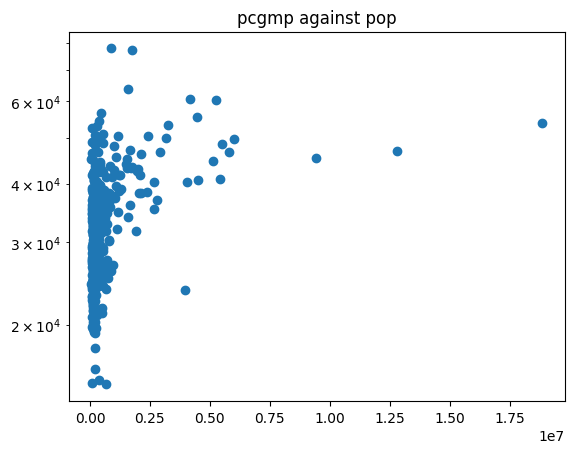

In [211]:
plt.scatter((bea_df['pop']), bea_df['pcgmp'])
plt.yscale('log')
plt.title('pcgmp against pop');

Using a log scale for the population axis is somewhat more informative: we see that as the population size increases, there seems to be an increasing lower limit on the GMP per capita.

**Linear regression assumptions**

* Distribution of X is arbitrary and might even be deterministic
* Functional form of $f(.)$ in $Y = f(X) + \epsilon$ is linear in the parameters
* Expected value of $\epsilon_i$ is 0
* Variance of $\epsilon_i$ is finite and homoscedastic
* $\epsilon$ is uncorrelated across observations

# Boston house prices dataset (from 1978!)

Each row in this dataset corresponds to a suburb or town.

In [168]:
# useful descriptions about these columns were obtained from: https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8
housing_columns = [
    'crim',    # per capita crime rate
    'zn',      # fraction of residential land is "zoned" for lots over 25,000 sqft
    'indus',   # fraction of non-retail business acres per town
    'chas',    # Charles river dummy variables (1 if tract bounds the river)
    'nox',     # nitric oxide concentration in pp10m
    'rm',      # average number of rooms per dwelling
    'age',     # fraction of owner-occupied units built before 1940
    'dis',     # weighted distances to five boston employment centres
    'rad',     # index of accessibility to radial highways
    'tax',     # tax rate per $10,000
    'ptratio', # pupil-teach ratio
    'medv',    # median value of owner-occupied homes in $1000s
    'black',   # 1000 * (bk - 0.63) ^ 2 where bk is the fraction of black people in the town
    'lstat',   # % of population that are low status (1/2 * (proportion of adults without some high school education and proportion of male workers classified as laborers))
]

housing_df = pd.read_csv('boston-housing/train.txt')
housing_df

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,500,0.17783,0.0,9.69,0,0.585,5.569,73.5,2.3999,6,391,19.2,395.77,15.10,17.5
329,502,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
330,503,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
331,504,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9


In [155]:
housing_df.describe()

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000
mean,250.951952,3.360341,10.689189,11.293483,0.060060,0.557144,6.265619,68.226426,3.709934,9.633634,409.279279,18.448048,359.466096,12.515435,22.768769
std,147.859438,7.352272,22.674762,6.998123,0.237956,0.114955,0.703952,28.133344,1.981123,8.742174,170.841988,2.151821,86.584567,7.067781,9.173468
min,1.000000,0.006320,0.000000,0.740000,0.000000,0.385000,3.561000,6.000000,1.129600,1.000000,188.000000,12.600000,3.500000,1.730000,5.000000
25%,123.000000,0.078960,0.000000,5.130000,0.000000,0.453000,5.884000,45.400000,2.122400,4.000000,279.000000,17.400000,376.730000,7.180000,17.400000
50%,244.000000,0.261690,0.000000,9.900000,0.000000,0.538000,6.202000,76.700000,3.092300,5.000000,330.000000,19.000000,392.050000,10.970000,21.600000
75%,377.000000,3.678220,12.500000,18.100000,0.000000,0.631000,6.595000,93.800000,5.116700,24.000000,666.000000,20.200000,396.240000,16.420000,25.000000
max,506.000000,73.534100,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,21.200000,396.900000,37.970000,50.000000


In [156]:
housing_df.isna().sum(axis=0)

ID         0
crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

There were 215.0 counts of a per capita crime rate of zero.
Conversely, there were 118.0 counts of a per capita crime rate of one or higher.


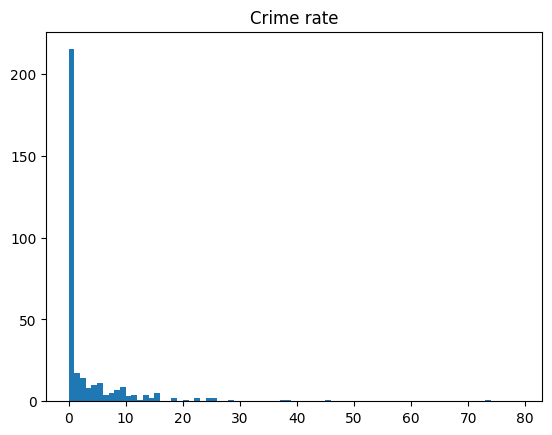

In [157]:
counts, _, _ = plt.hist(housing_df['crim'], bins=[x for x in range(0,80,1)])
plt.title('Crime rate')
print(f'There were {counts[0]} counts of a per capita crime rate of zero.')
print(f'Conversely, there were {sum(counts[1:])} counts of a per capita crime rate of one or higher.')

The histogram of the per capita crime rate seems to make sense. It seems that the majority of suburbs have a per capita crime rate between 0 and 1, i.e. most suburbs (215 out of 333 to be precise) see very few crimes. After 0-1, the count drops sharply and it looks there is a long tail in the per capita crime rate.

Dropping the count for 0-1 per capita crime rate might help us visualise the data better.

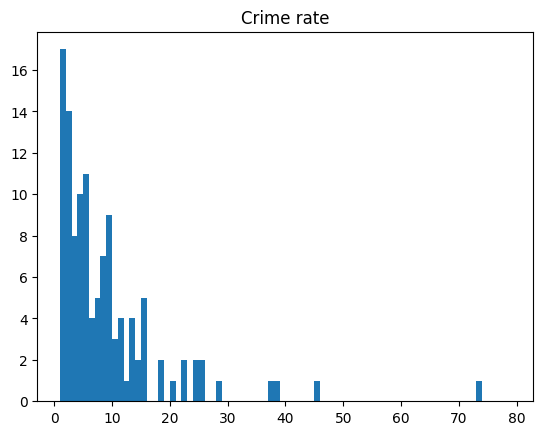

In [158]:
counts, _, _ = plt.hist(housing_df['crim'], bins=[x for x in range(1,80,1)])
plt.title('Crime rate');

Seems to be an polynomial drop in the crime rate. Not sure if that one count of >70 crime rate indicates fat-tailedness.

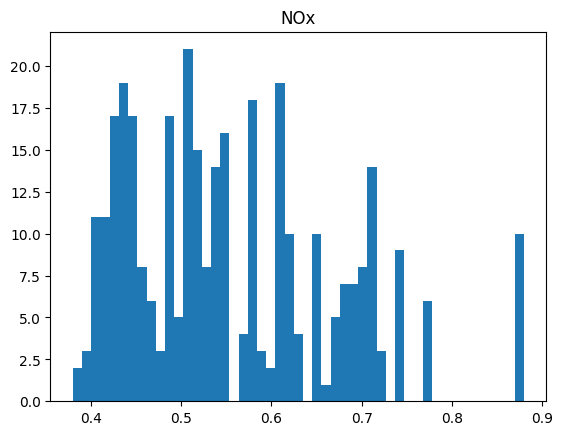

In [159]:
plt.hist(housing_df['nox'], bins=np.linspace(0.38, 0.88, 50))
plt.title('NOx');

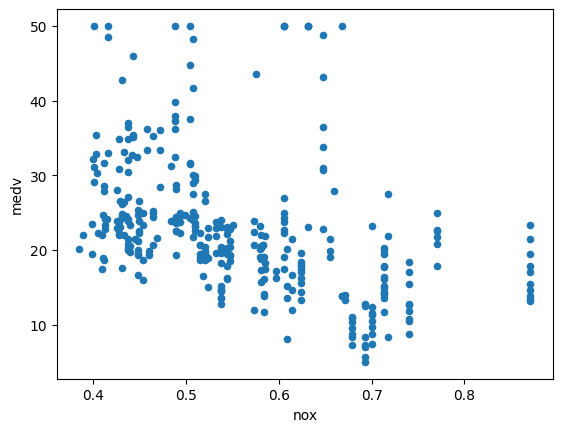

In [160]:
housing_df.plot('nox', 'medv', kind='scatter');

[The Harrison and Rubinfeld paper](https://www.sciencedirect.com/science/article/pii/0095069678900062) from which the housing price dataset is from proports to make a connection between NOx and median house price, but I can't see any useful patterns in the NOx concentrations here.

**Dealing with the problematic `black` column**

The `black` column was obtained by computing $\texttt{black} = 1000 (\texttt{bk} - 0.63)^2$, which is a parabolic relationship (`bk` is the percentage of the population that is black). This is problematic because it means multiple values of `bk` may map to the same value of `black`, so we can't always get back `bk` based on `black`. In particular, values of `black` lower than 136.9 could have been obtained from either one of two values of `bk` (see plot below). Therefore we ignore the rows which have $\texttt{black} < 136.9$ since they're non-invertible.

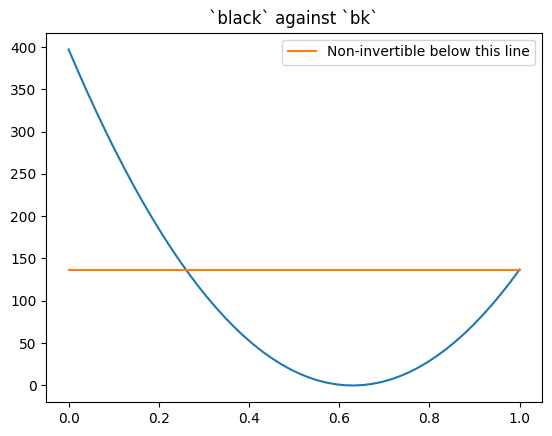

In [161]:
bk = np.linspace(0,1) # this is a percentage so should be between 0 and 1
black = 1000 * (bk - 0.63) ** 2
plt.plot(bk, black)
plt.plot([0,1], [black[-1], black[-1]], label='Non-invertible below this line')
plt.legend()
plt.title('`black` against `bk`');

In [216]:
# dropping rows with non-invertible values of black
housing_df.drop(housing_df[housing_df['black'] < 136.9].index, inplace=True)
assert np.min(housing_df['black']) >= 136.9, 'Non-invertible values of black have not been dropped'
housing_df['black_inv'] = 0.63 - np.sqrt(housing_df['black'] / 1000)

0.00632


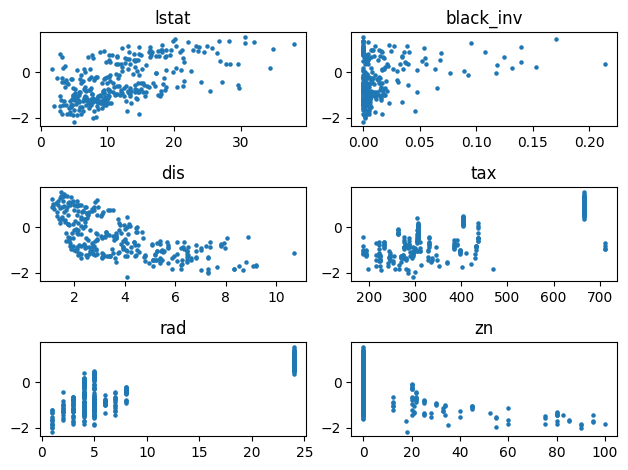

In [205]:
def scatter_crime(features):
    n = len(features)
    fig, axs = plt.subplots(ncols=2, nrows=math.ceil(n/2))
    for ax, feature in zip(axs.flat, features):
        ax.scatter(housing_df[feature], np.log10(housing_df['crim']), s=5)
        ax.set_title(feature)
    fig.tight_layout()

features = ['lstat', 'black_inv', 'dis', 'tax', 'rad', 'zn']
scatter_crime(features)

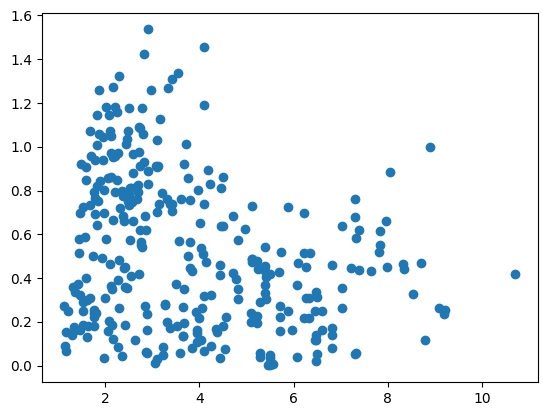

In [271]:
dis_trans = housing_df['dis'].values.reshape(-1,1) ** (-1/2)
linear_model = sk_linear_model.LinearRegression().fit(dis_trans, np.log10(housing_df['crim']))
crim_pred = linear_model.predict(dis_trans)
r = np.log10(housing_df['crim']) - crim_pred
plt.scatter(housing_df['dis'], np.abs(r));